In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display_html, display, Math, HTML
import warnings
warnings.filterwarnings("ignore")

# Poisson Processes

```{margin}
These sections continue to draw on [Think Bayes](https://greenteapress.com/wp/think-bayes) by Allen B. Downey.
```

Recall, a Poisson process is a model used to describe events that occur at random intervals. Today we'll look at how a Poisson process can be used to model goal-scoring in soccer using a Bayesian approach. This problem will incoporate everything we've learned about Bayesian infrence so far.

However, before we start with our soccer model we need to introduce some new concepts. We will start by looking at how to compute a distribution which is a sum, difference, or a mixture of other distributions. 

### Adding, Subtracting, and Mixing Distributions

If I ask you to tell me the expected value of sum of a six-sided die and a four-sided die, all of you know immedately that you just need to sum their individual expected values thanks to the linearity of expectation.

But what is the distribution of the sum of these two dice?

If we roll two dice and add them up, there are 9 possible outcomes, 2 through 10, but they are not equally likely. To compute the distribution of the sum, we have to enumerate the possible outcomes and determine their probailites.

A total of 2 can only happen one way: a 1 on the six sided die and a 1 on the four sided die. That means the probability of a 2 is $(1/6)*(1/4)$.

We can make a table for all possible outcomes:

| Total | Posbbile Die Rolls | Probability |
| --- | --- | --- | 
| 2 | (1,1) | (1/6)(1/4) |
| 3 | (1,2) and (2,1) |  (1/6)(1/4) + (1/6)(1/4) = 2(1/6)(1/4) |
| 4 | (1,3), (2,2), and (3,1) | 3(1/6)(1/4) |

And so on... While annoying to calculate by hand, the sum of disributions is pretty straightforward in code.

In [2]:
dice1 = pd.DataFrame(index = np.arange(1,5))
dice1['probs'] = 1/4
dice2 = pd.DataFrame(index = np.arange(1,7))
dice2['probs'] = 1/6

def add_dist(dist1, dist2):
    """Compute the distribution of a sum."""
    res = dict()
    for index1, row1 in dist1.iterrows():
        for index2, row2 in dist2.iterrows():
            q = index1 + index2
            p = row1['probs'] * row2['probs']
            if q in res: 
                res[q] = res[q] + p
            else:
                res[q] =  p
    return res
            
add_dist(dice1, dice2)

{2: 0.041666666666666664,
 3: 0.08333333333333333,
 4: 0.125,
 5: 0.16666666666666666,
 6: 0.16666666666666666,
 7: 0.16666666666666666,
 8: 0.125,
 9: 0.08333333333333333,
 10: 0.041666666666666664}

Subtraction follows the same principle except the outcomes are subtracted from each other.
Calculating a **mixture** of two (or more) distributions is a related problem.

Let's say you're playing Dungeons & Dragons:

    - Your character is armed with a dagger in one hand and a short sword in the other.
    - During each round, you attack a monster with one of your two weapons, chosen at random.
    - The dagger causes one 4-sided die of damage; the short sword causes one 6-sided die of damage.

```{margin} 
Image credit: DALL-E, prompt: "Dungeons and  Dragons character is armed with a dagger in one hand and a short sword in the other photorealistic"
```

<center>
    
<img src="images/DALLE-Dungeons-and-Dragons-character-is-armed-with-a-dagger-in-one-hand-and-a-short-sword-in-the-other-photorealistic.png" width="400px">
    
</center>

What is the distribution of damage you inflict in each round?

Let's think about this by enumerating the ways you can do any given amount of damage:

Let’s compute the probability you inflict 1 point of damage.

    If you attacked with the dagger, it’s 1/4.

    If you attacked with the short sword, it’s 1/6.

Because the probability of choosing either weapon is 1/2, the total probability is:

$$p(\text{1 damage}) = (1/2)*(1/4) + (1/2)*(1/6) = 5/24 = 0.21$$

The probabilites for 2,3 and 4 damage are the same, but what about for 5?

Only the short sword can do 5 (or 6) damage so:

$$p(\text{5 damage}) = (1/2)*(0) + (1/2)*(1/6) = 1/12 = 0.08$$

We can actually pretty simply write a general function that does this for us.

Start by creating a table of all outcomes and all probabilities across the distributions:

In [3]:
dice1 = pd.DataFrame(index = np.arange(1,5))
dice1['probs'] = 1/4
dice2 = pd.DataFrame(index = np.arange(1,7))
dice2['probs'] = 1/6

#make table
mix = dice1.transpose().append(dice2.transpose(), ignore_index=True).fillna(0)
mix

,1,2,3,4,5,6
0,0.250000,0.250000,0.250000,0.250000,0.000000,0.000000
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667


Then multiply each distribution by its probability:

In [4]:
prob_of_dice = [.5,.5]

#multiply by probability
mix = mix.transpose()*prob_of_dice
mix

,0,1
1,0.125,0.083333
2,0.125,0.083333
3,0.125,0.083333
4,0.125,0.083333
5,0.000,0.083333
6,0.000,0.083333


And finally sum across the probabilities:

In [5]:
#sum to get final mix
mix = mix.sum(axis=1)
mix

1    0.208333
2    0.208333
3    0.208333
4    0.208333
5    0.083333
6    0.083333
dtype: float64

Let's rewrite that as a general function:

In [6]:
def make_mixture(pmf_table, probs):
    """Make a mixture of distributions."""
    mix = pmf_table.fillna(0)
    mix = mix.transpose()*probs
    mix = mix.sum(axis=1)
    return mix

make_mixture(dice1.transpose().append(dice2.transpose(), ignore_index=True), prob_of_dice)

1    0.208333
2    0.208333
3    0.208333
4    0.208333
5    0.083333
6    0.083333
dtype: float64

Now let's suppose you are fighting 3 monsters:

    One has a club, which causes one 4-sided die of damage.

    One has a mace, which causes one 6-sided die.

    One has a quarterstaff, which also causes one 6-sided die.

Because the melee is disorganized, you are attacked by one of these monsters each round, chosen at random. Find the distribution of the damage they inflict.

In [7]:
dice1 = pd.DataFrame(index = np.arange(1,5))
dice1['probs'] = 1/4
dice2 = pd.DataFrame(index = np.arange(1,7))
dice2['probs'] = 1/6

prob_of_dice = [1/3,1/3,1/3]

pmf_table = dice1.transpose().append(dice2.transpose(), ignore_index=True).append(dice2.transpose(), ignore_index=True)

make_mixture(pmf_table, prob_of_dice)

1    0.194444
2    0.194444
3    0.194444
4    0.194444
5    0.111111
6    0.111111
dtype: float64

Now that we know how mixture distributions work, we can return to the original goal of this lecture: using the Poisson process to model goal-scoring in soccer.

## The World Cup Problem

In the 2018 FIFA World Cup final, France defeated Croatia 4 goals to 2. Based on this outcome:

    1. How confident should we be that France is the better team?
    2. If the same teams played again, what is the chance France would win again?


```{margin} 
Image credit: DALL-E, prompt: "Anime drawing of a French soccer player scoring a goal against croatian goalie in the world cup"
```

<center>
    
<img src="images/DALLE-Anime-drawing-of-a-French-soccer-player-scoring-a-goal-against-croatian-goalie-in-the-world-cup.png" width="400px">
    
</center>

### Approaching the problem

To sove this problem we'll have to make a few basic assumptions:

   1. We'll assume that any team has some unknown goal-scoring rate $\lambda$, measured in goals per game.
   2. We'll assume that a goal is equally likely during any minute of a game. So, in a 90 minute game, the probability of scoring during any minute is $\lambda / 90$.
   3. A team can't score more than once in a minute.
 
These assumption directly point to goals following a Poisson distribution.

### Poisson Review

So let's quickly review the Poisson distribution:

$$ P[k \mbox{ successes in time } T] = (\lambda T)^k \frac{e^{- \lambda T}}{k!}$$

We'll set the time interval to 1 to represent the whole game:

$$ P[k \mbox{ goals in a game } ] = \lambda^k \frac{e^{- \lambda}}{k!}$$


So if a team averages 2 goals per game, the probability of scoring 4 goals is:

$$ P[k=4] =2^4 \frac{e^{-2}}{4!} = 0.09$$


And in code:

In [8]:
from scipy.stats import poisson

goals = 4
lam = 2
poisson.pmf(goals, lam)

0.09022352215774178

### Taking a Bayesian View

For this problem we'll need to update probabilities based on goals, so what we need to think about is a little bit reversed: **given a number of goals, what can we say about the goal-scoring rate?**

This means we need to think about a prior distribution for the goal scoring rate $\lambda$.

It makes sense to set this based on some historical value of the average number of times team score per game in past world cups. It turns out this value is **1.4**.

Of couse we expect some teams to score more goals per game and some teams to score fewer (so it has to be a distribution).

We also know that the goal rate can't be negative (so a normal distribution is right out).

It's also pretty rare for teams to have very high goal scoring rates.

It turns out there's a pretty good distribuion to model this called a **gamma distribution**. It has two parameters, it's never negative, and decays quickly. 

This is what it looks like:

In [9]:
from scipy.stats import gamma

gamma = [gamma.pdf(lam, 1.4) for lam in np.arange(0, 10, .1)]

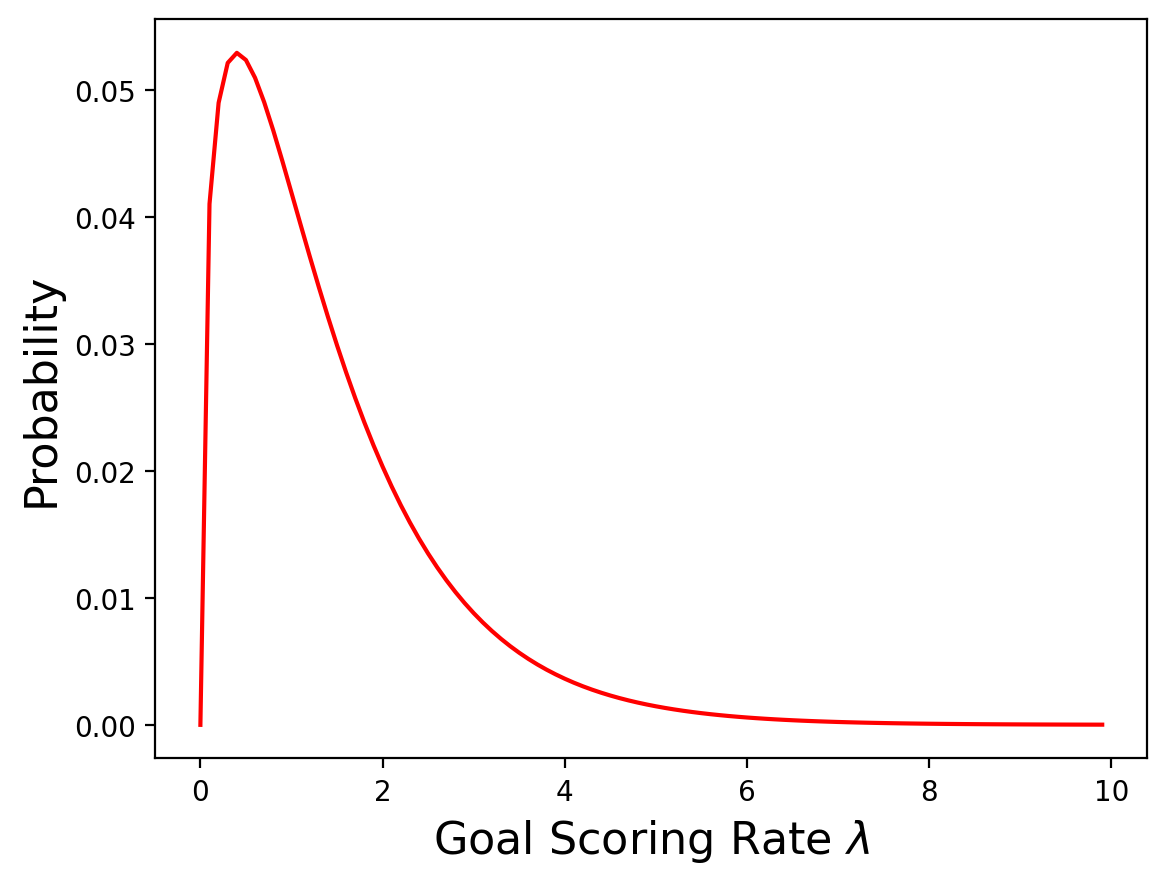

In [10]:
plt.plot(np.arange(0, 10, .1), gamma/sum(gamma), color="red")
plt.xlabel('Goal Scoring Rate $\lambda$', size = 16)
plt.ylabel('Probability', size = 16);

Of course different people might choose different priors, but this seems like a reasonable choice. Most teams score fewer than 2 goals per game.

A gamma distribution also has a very special relationship to the Poisson distribution which we will discuss in detail when we talk about **conjugate priors**.

### The Update

If we have an array of possible values for $\lambda$ we can compute the likelihood of the data for each hypothetical value. The posterior is just the prior times the likelihood (normalized). We'll use our standard update function:

In [11]:
def likelihood_poisson(lam, data):
    '''Returns the likelihood of seeing a k goals for goal scoring rate lambda'''
    return [poisson.pmf(data, l)  for l in lam]
    
def update(distribution, likelihood):
    '''our standard Bayesian update function'''
    distribution['probs'] = distribution['probs'] * likelihood
    prob_data = distribution['probs'].sum()
    distribution['probs'] = distribution['probs'] / prob_data
    return distribution

prior = pd.DataFrame({'lams':np.arange(0, 10, .1),'probs':gamma/sum(gamma)})
france = prior.copy()
update(france, likelihood_poisson(france['lams'], 4));

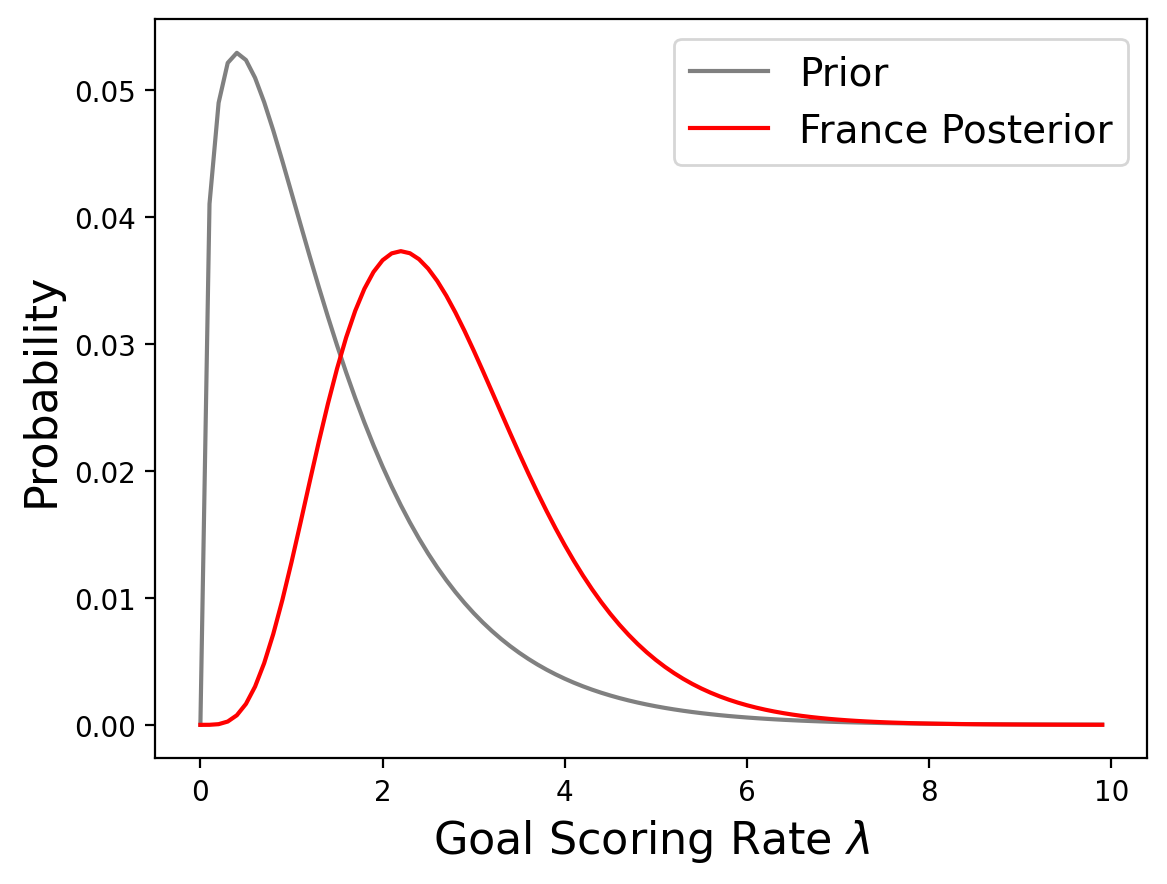

In [12]:
plt.plot(prior['lams'], prior['probs'], color="gray")
plt.plot(france['lams'], france['probs'], color="red")
plt.legend(['Prior', 'France Posterior'], fontsize = 14, loc = 'best')
plt.xlabel('Goal Scoring Rate $\lambda$', size = 16)
plt.ylabel('Probability', size = 16);

Let's do the same for Croatia:

In [13]:
croatia = prior.copy()
update(croatia, likelihood_poisson(croatia['lams'], 2));

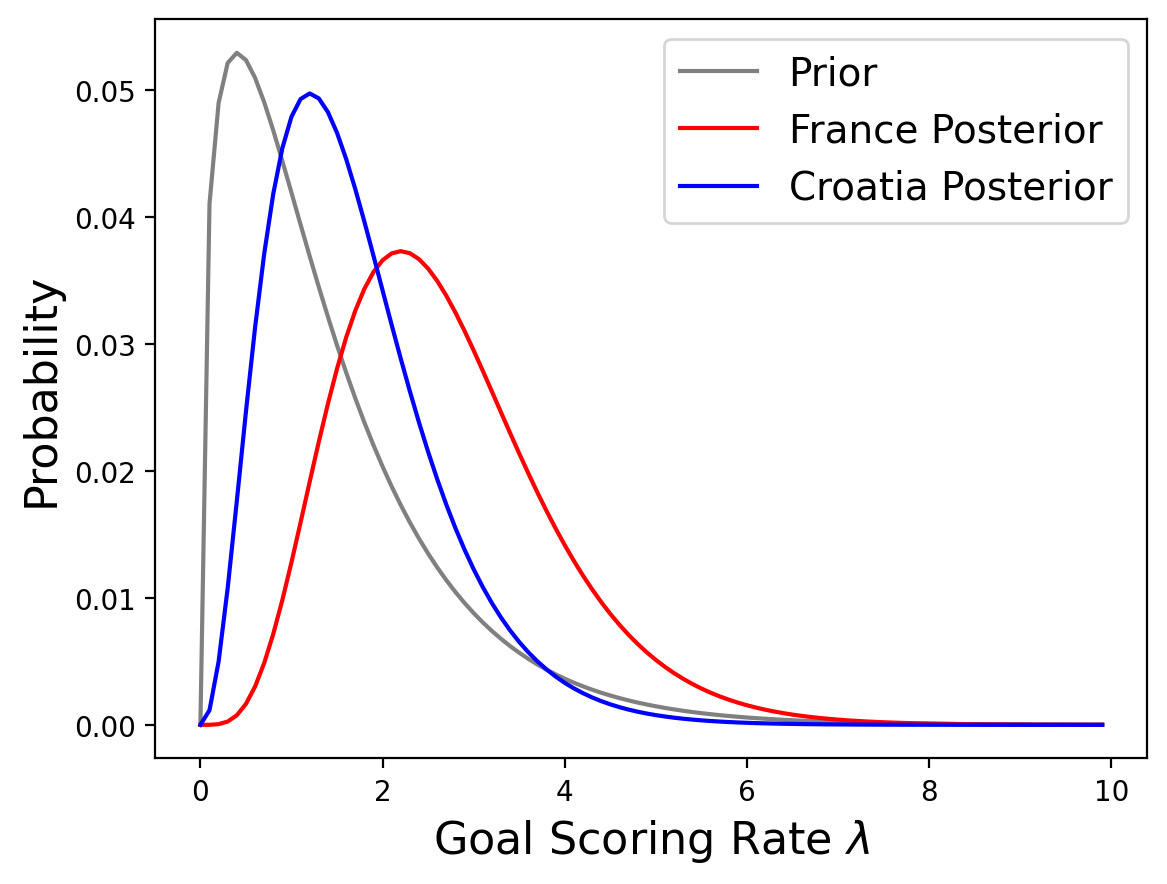

In [14]:
plt.plot(prior['lams'], prior['probs'], color="gray")
plt.plot(france['lams'], france['probs'], color="red")
plt.plot(france['lams'], croatia['probs'], color="blue")
plt.legend(['Prior', 'France Posterior', 'Croatia Posterior'], fontsize = 14, loc = 'best')
plt.xlabel('Goal Scoring Rate $\lambda$', size = 16)
plt.ylabel('Probability', size = 16);

So it looks like France is better, but going back to the original question, how confident should we be that France is the better team?

### Probability of Superiority

Fundementally to answer this we want to answer "what is the probability that a random value drawn from France’s distribution exceeds a value drawn from Croatia’s"

The way to do this is to enumerate all pairs of values from the two distributions, adding up the total probability that one value exceeds the other.


For example, someone might ask "what is the probabilty that a six-sided die rolls a higher number than a four-sided die?" This would be the probability of superiorty of the six-sided die.

If the first die rolls a 6, that would be higher than any outcome (1,2,3, or 4) for the second die. This happens 1/6 of the time.

We can make a table for all possible outcomes:

| Die 1 | Greater than what on die 2 | Probability |
| --- | --- | --- |
| 6 |  1,2,3,4 | $1/6*1$ |
| 5 |  1,2,3,4 | $1/6*1$ |
| 4 |  1,2,3 | $1/6*3/4$ |
| 3 |  1,2 | $1/6*1/2$ |
| 2 |  1 | $1/6*1/4$ |
| 1 |  no values | $1/6*0$ |


If we take the sum of those probabilities we get the **Probability of Superiority** of a six-sided die over a four-sided die. 

The sum is 1/6(1+1+3/4+1/2+1/4) = 7/12

Calculating this by hand for the posterior distributions for the French and Croatian goal scoring rates would be way too time consuming, but this is actually not too complex to calculate in code:

In [15]:
def prob_of_s(dist1, dist2):
    """Compute the probability of superiority."""
    total = 0
    for index1, row1 in dist1.iterrows():
        for index2, row2 in dist2.iterrows():
            if row1['lams'] > row2['lams']:
                total += row1['probs'] * row2['probs']
    return total

prob_of_s(france, croatia)

0.7499355407920673

 So, on the basis of one game, we have moderate confidence that France is actually the better team.

### Predicting a Rematch

Now lets take a look at the second question: "If the same teams played again, what is the chance France would win again?"

To answer this question we need to think about the number of goals we expect a team to score.

If we knew the goal scoring rate $\lambda$, the distribution of goals would be a Poisson distribution with parameter $\lambda$. Since we don’t know $\lambda$, the distribution of goals is a mixture of a Poisson distributions with different values of  $\lambda$.

So first we need Poisson distributions for each value of $\lambda$.

In [21]:
pmf_table = pd.DataFrame([[poisson.pmf(goals,lam) for goals in range(10)] for lam in prior['lams']])
pmf_table = (pmf_table.T / pmf_table.T.sum()).T
pmf_table

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.904837,0.090484,0.004524,0.000151,0.000004,7.540312e-08,1.256719e-09,1.795312e-11,2.244140e-13,2.493489e-15
2,0.818731,0.163746,0.016375,0.001092,0.000055,2.183282e-06,7.277607e-08,2.079316e-09,5.198290e-11,1.155176e-12
3,0.740818,0.222245,0.033337,0.003334,0.000250,1.500157e-05,7.500784e-07,3.214622e-08,1.205483e-09,4.018277e-11
4,0.670320,0.268128,0.053626,0.007150,0.000715,5.720064e-05,3.813376e-06,2.179072e-07,1.089536e-08,4.842383e-10
...,...,...,...,...,...,...,...,...,...,...
95,0.000143,0.001363,0.006473,0.020497,0.048681,9.249398e-02,1.464488e-01,1.987519e-01,2.360179e-01,2.491300e-01
96,0.000133,0.001278,0.006133,0.019626,0.047103,9.043735e-02,1.446998e-01,1.984454e-01,2.381345e-01,2.540101e-01
97,0.000124,0.001199,0.005813,0.018795,0.045578,8.842148e-02,1.429481e-01,1.980852e-01,2.401783e-01,2.588588e-01
98,0.000115,0.001125,0.005511,0.018002,0.044105,8.644639e-02,1.411958e-01,1.976741e-01,2.421507e-01,2.636753e-01


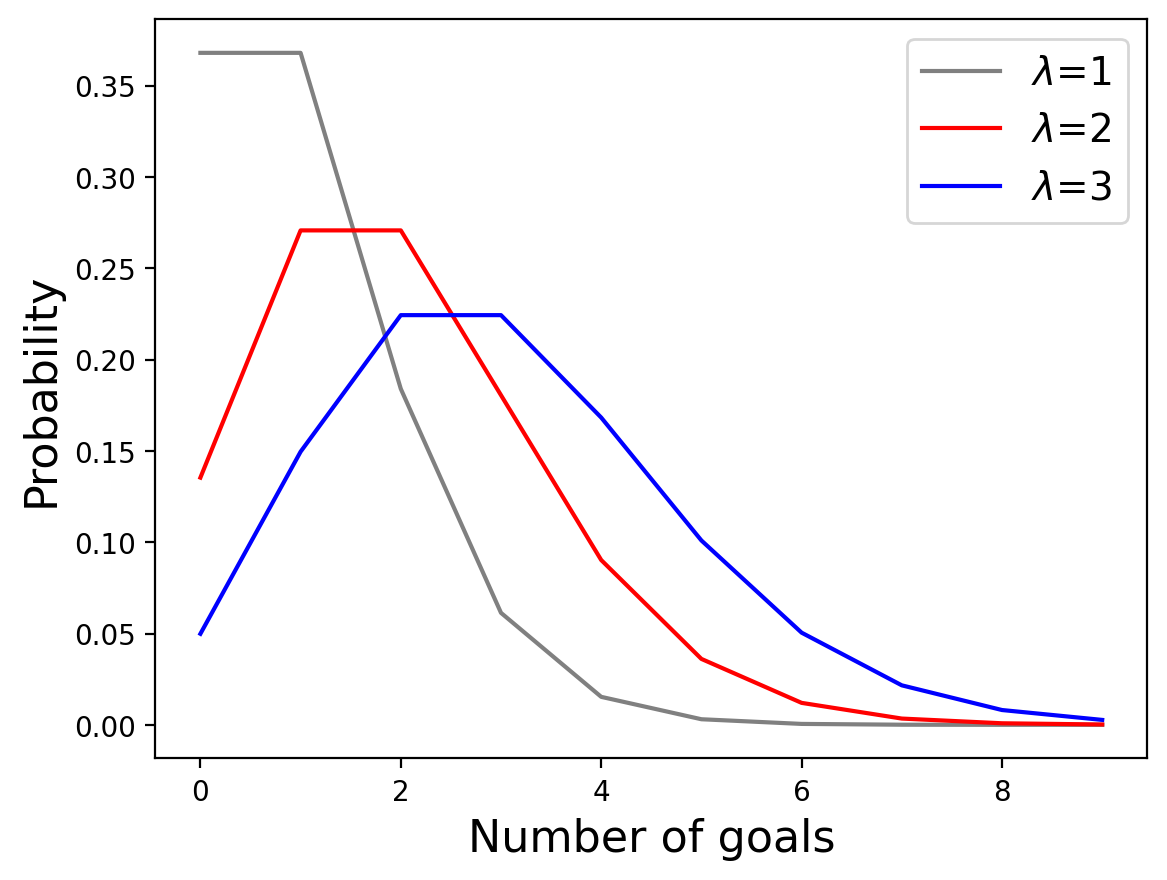

In [17]:
plt.plot(range(10), pmf_table.T[10], color="gray")
plt.plot(range(10), pmf_table.T[20], color="red")
plt.plot(range(10), pmf_table.T[30], color="blue")
plt.legend(['$\lambda$=1', '$\lambda$=2', '$\lambda$=3'], fontsize = 14, loc = 'best')
plt.xlabel('Number of goals', size = 16)
plt.ylabel('Probability', size = 16);

The "posterior predictive distribution”, which is the number of goals we expect a team to score, is the mixture of these distributions scaled by the posterior probabilities of the $\lambda$s for each team.

In [18]:
pred_france = make_mixture(pmf_table, france['probs'])
pred_croatia = make_mixture(pmf_table, croatia['probs'])

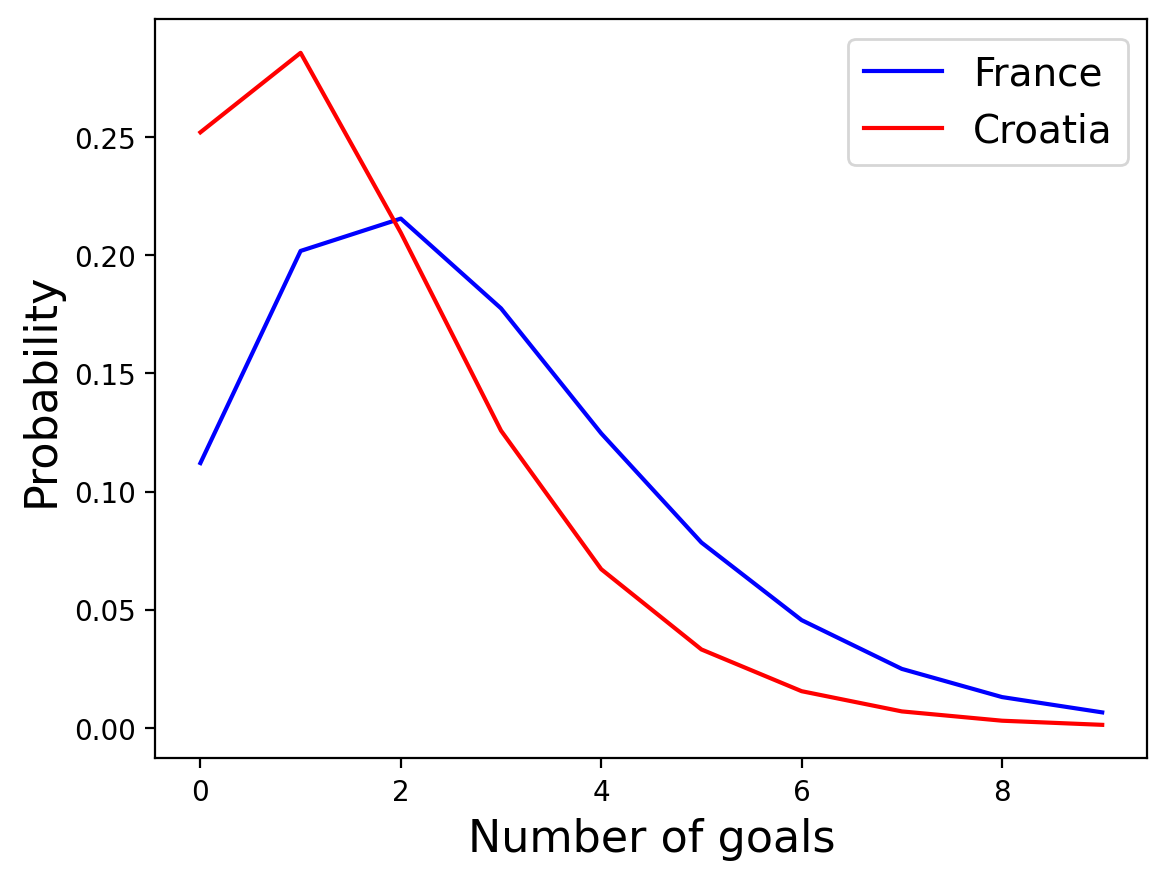

In [19]:
plt.plot(range(10), pred_france, color="blue")
plt.plot(range(10),pred_croatia, color="red")
plt.legend(['France', 'Croatia'], fontsize = 14, loc = 'best')
plt.xlabel('Number of goals', size = 16)
plt.ylabel('Probability', size = 16);

In [20]:
prob_of_s(pd.DataFrame({'lams':range(10), 'probs':pred_france}),pd.DataFrame({'lams':range(10), 'probs':pred_croatia}))

0.5703503557878827

So theres about a 57% chance France would win a rematch!